#### Large RAM is required to load the larger models. Running on GPU can optimize inference speed.

In [1]:
#!pip3 install salesforce-lavis

  Using cached salesforce_lavis-1.0.0-py3-none-any.whl (495 kB)
  Using cached streamlit-1.18.1-py2.py3-none-any.whl (9.6 MB)
  Using cached python_magic-0.4.27-py2.py3-none-any.whl (13 kB)
     -------------------------------------- 377.0/377.0 kB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 17.6 MB/s eta 0:00:00
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached einops-0.6.0-py3-none-any.whl (41 kB)
  Using cached webdataset-0.2.33-py3-none-any.whl (51 kB)
     ------------------------------------- 202.2/202.2 kB 12.8 MB/s eta 0:00:00
  Using cached spacy-3.5.0-cp38-cp38-win_amd64.whl (12.6 MB)
  Using cached pandas-1.5.3-cp38-cp38-win_amd64.whl (11.0 MB)
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Using cached sentencepiece-0.1.97-cp38-cp38-win_amd64.whl (1.1 MB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached opencv_python_headless-4.5.5.64-cp36-abi3-win_amd64.whl (35.3 MB)
     -------------------

#### Load an example image

In [1]:
import sys # if needed
import torch
from PIL import Image
import requests #if needed
from lavis.models import load_model_and_preprocess

c:\Users\zbagl\anaconda3\envs\blip2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


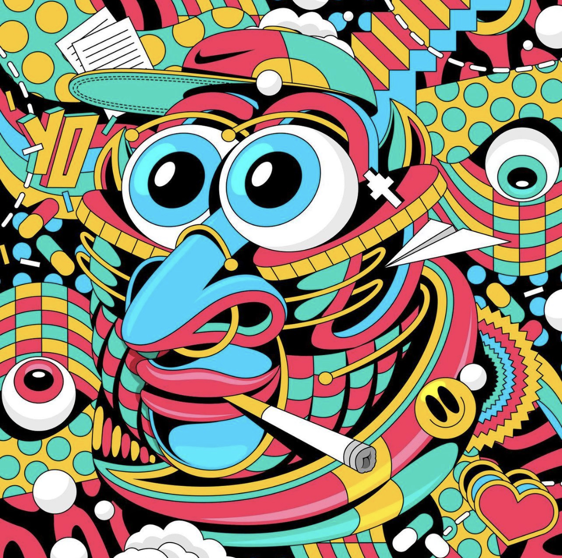

In [2]:
img_url = r"H:\Datasets\DOMINIC\VectorPop\VectorPop\IMG_4541.jpeg"
raw_image = Image.open(img_url).convert('RGB')   
display(raw_image.resize((raw_image.width//2, raw_image.height//2)))

#### Load pretrained/finetuned BLIP2 captioning model

In [3]:
# Tries to dump cached GPU memory... may cause performance issues / kernel errors

import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu" # setup device to use

# we associate a model with its preprocessors to make it easier for inference.
#model, vis_processors, _ = load_model_and_preprocess(
#    name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device # Super huge model, need more than 24GB of GPU memory
#)

# Other available models:
# 
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
#
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
)
#
#
#model, vis_processors, _ = load_model_and_preprocess(
#    name='blip2_t5', model_type='pretrain_flant5xl', is_eval=True, device=device
#)
#
#model, vis_processors, _ = load_model_and_preprocess(
#    name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
#)

vis_processors.keys()

image = vis_processors["eval"](raw_image).unsqueeze(0).to(device) # prepare the image as model input using the associated processors

Position interpolate from 16x16 to 26x26


Loading checkpoint shards: 100%|██████████| 2/2 [00:35<00:00, 17.96s/it]


NameError: name 'raw_image' is not defined

#### batch captioning from directory

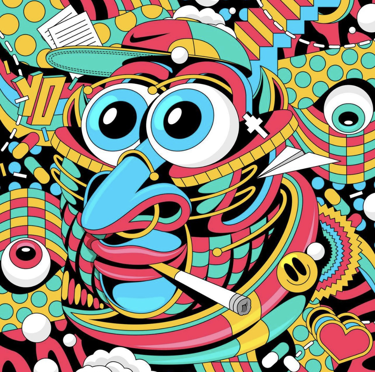

['a colorful pattern with many different things on it']


In [8]:
import os
from pathlib import Path
from IPython.display import clear_output

imagesDirectory = "H:\Datasets\KHOYA\Training" #Directory here

suspects = os.listdir(imagesDirectory) #@param{type:"string"}
imageSuspects = [ filename for filename in suspects if filename.endswith( (".jpg", ".png", ".jpeg") ) ]

for suspectIndex in range(len(imageSuspects)):
    # Load Image
    imagePath = imageSuspects[suspectIndex]
    imageFilePath = imagesDirectory + "/" + imagePath
    rawImage = Image.open(imageFilePath).convert('RGB')   
    display(raw_image.resize((raw_image.width//3, raw_image.height//3)))
    # Prepare Model using Image
    image = vis_processors["eval"](rawImage).unsqueeze(0).to(device)
    # Generate Caption using beam search
    caption = model.generate({"image": image})
    print(caption)
    
    # Save Caption as .txt file
    textFilePath = Path(imageFilePath).with_suffix('.txt')
    if os.path.exists(textFilePath):
        os.remove(textFilePath)
    with open(textFilePath, 'w+') as f:
        f.write(caption[0])
    clear_output(wait=True)

#### generate caption using beam search - single caption

In [4]:
model.generate({"image": image})

['an illustration of an owl with a cigarette in his mouth']

#### generate multiple captions using nucleus sampling

In [13]:
# due to the non-determinstic nature of necleus sampling, you may get different captions.
max_length = 25
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=5)

['a car parked in front of a 7-11 convenience store',
 'a car parked outside of a 7-11 store',
 'a car parked in front of a 7-11 store',
 'a car parked in front of a 7/11 store',
 'a car is parked outside a store']

#### instructed zero-shot vision-to-language generation

In [23]:
# comment here to prevent run on run-all
model.generate({"image": image, "prompt": "Question: what city is in the photo? Answer:"})

['san francisco']

In [24]:
# comment here to prevent run on run-all
model.generate({
    "image": image,
    "prompt": "Question: which city is this? Answer: san francisco. Question: why?"})

['']

In [25]:
# comment here to prevent run on run-all
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: which city is this? Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [26]:
# comment here to prevent run on run-all
model.generate(
    {
    "image": image,
    "prompt": prompt
    },
    use_nucleus_sampling=False,
)

['singapore.']